# Using EA player statistics to predict match results: win / draw / loss
We'll use logistic regression and random forests to classify game result with `scikit-learn`. Results are shown for different sets of features. Initally we use only the mean `overall_rating` statistic for __4 player groups__: 

 - __F__=forward (striker), __M__=midfield, __D__=defense, __G__=goalie.
 
Then, we'll include more detailed EA statistics such as `crossing`, `finishing`, `heading_accuracy`, etc... These will still be binned in average groups along with the `overall_rating` based on position, so we'll end up with `2*[len(EA_player_stats)*3 + len(EA_goalie_stats)] = 180` features per sample. Totalling up the matches from all leagues we have ~25,000 samples.

You are welcome to skip the __feature extraction__ section below and skip to __implementing classifiers with `sci-kit learn`__

In [141]:
import warnings
warnings.filterwarnings('ignore')

In [142]:
import sys
sys.path.append('C:\Anaconda3\Lib\site-packages')
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt


## Feature extraction / engineering

Using `SQLite` to query the database and `Pandas` to store features in memory.

In [143]:
conn = sqlite3.connect('../input/database.sqlite')
c = conn.cursor()

**League ID dictionary**


In [144]:
ids = [i[0] for i in c.execute('SELECT id FROM League').fetchall()]
names = [i[0] for i in c.execute('SELECT name FROM League').fetchall()]
id_league = {i: n for i, n in zip(ids, names)}
id_league

{1: 'Belgium Jupiler League',
 1729: 'England Premier League',
 4735: 'France Ligue 1',
 7775: 'Germany 1. Bundesliga',
 10223: 'Italy Serie A',
 13240: 'Netherlands Eredivisie',
 15688: 'Poland Ekstraklasa',
 17608: 'Portugal Liga ZON Sagres',
 19660: 'Scotland Premier League',
 21484: 'Spain LIGA BBVA',
 24524: 'Switzerland Super League'}

In [145]:
# Country ID
ids = [i[0] for i in c.execute('SELECT id FROM Country').fetchall()]
names = [i[0] for i in c.execute('SELECT name FROM Country').fetchall()]
id_country = {i: n for i, n in zip(ids, names)};

**What EA Sports FIFA stats do we have?**

In [146]:
c.execute('PRAGMA TABLE_INFO(Player_Stats)').fetchall()

[(0, 'id', 'INTEGER', 0, None, 1),
 (1, 'player_fifa_api_id', 'INTEGER', 0, None, 0),
 (2, 'player_api_id', 'INTEGER', 0, None, 0),
 (3, 'date_stat', 'TEXT', 0, None, 0),
 (4, 'overall_rating', 'INTEGER', 0, None, 0),
 (5, 'potential', 'INTEGER', 0, None, 0),
 (6, 'preferred_foot', 'TEXT', 0, None, 0),
 (7, 'attacking_work_rate', 'TEXT', 0, None, 0),
 (8, 'defensive_work_rate', 'TEXT', 0, None, 0),
 (9, 'crossing', 'INTEGER', 0, None, 0),
 (10, 'finishing', 'INTEGER', 0, None, 0),
 (11, 'heading_accuracy', 'INTEGER', 0, None, 0),
 (12, 'short_passing', 'INTEGER', 0, None, 0),
 (13, 'volleys', 'INTEGER', 0, None, 0),
 (14, 'dribbling', 'INTEGER', 0, None, 0),
 (15, 'curve', 'INTEGER', 0, None, 0),
 (16, 'free_kick_accuracy', 'INTEGER', 0, None, 0),
 (17, 'long_passing', 'INTEGER', 0, None, 0),
 (18, 'ball_control', 'INTEGER', 0, None, 0),
 (19, 'acceleration', 'INTEGER', 0, None, 0),
 (20, 'sprint_speed', 'INTEGER', 0, None, 0),
 (21, 'agility', 'INTEGER', 0, None, 0),
 (22, 'reactions'

**Getting player stats for each game in the database**

We'll iterate over the `Match` table and get the stats for each player on the home and away teams using the `Player_Stats` table. Multiple rows of statistics exist for each player and we'll select the one whose datestamp most closely aligns with the game date.

The player position is determined using the player's 'Y' coordinate from the Match table. These coordinates are integers ranging from 1 to 11 (0 and None are assumed to be unknown). Based on the distribution below we'll define positions as follows:

 - G: Y=1  
 - D: Y=3     
 - M: Y=5-7     
 - F: Y=8-11     

In [147]:
cols = ", ".join(["home_player_Y"+str(i) for i in range(1,12)])
c.execute('SELECT {0:s} FROM Match'.\
         format(cols))
Y_array = c.fetchall()

Y = np.array([a for row in Y_array for a in row]) # flatten
from collections import Counter
print('Player Y value: # of instances in database (home players)')
Counter(Y)

Player Y value: # of instances in database (home players)


Counter({0: 22,
         1: 24115,
         3: 95293,
         5: 3102,
         6: 15641,
         7: 58108,
         8: 23067,
         9: 2782,
         10: 31864,
         11: 11271,
         None: 20130})

__Warning__: _very ugly function below to pool EA player stats for each game into a list. You may want to_ __skip down to the next section where we start visualizing the data.__

In [148]:
EA_stats = {'player': ', '.join(['overall_rating', #'attacking_work_rate', 'defensive_work_rate',
                                  'crossing', 'finishing', 'heading_accuracy', 'short_passing',
                                  'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
                                  'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
                                  'agility', 'reactions', 'balance', 'shot_power', 'jumping',
                                  'stamina', 'strength', 'long_shots', 'interceptions',
                                  'positioning', 'vision', 'penalties', 'marking',
                                  'standing_tackle', 'sliding_tackle']),
            'goalie': ', '.join(['gk_diving', 'gk_handling', 'gk_kicking',
                                 'gk_positioning', 'gk_reflexes'])}


def getTeamScores(match_id, team, EA_stats,
                  printout=False,
                  group='forward_mid_defense_goalie'):
    ''' Return the cumulative average team scores for 
    a given EA Sports FIFA statistic. If particular EA
    stats are not in the database that stat is taken as
    the overall player rating. If any positional stat is
    unavailable (i.e. no goalie information) that stat is
    taken as the average of the others for that team.
    team : str
        'home' or 'away'
    EA_stat : dict
        Names of statistics to cumulate for goalie and players.
        e.g. {'player': 'overall_rating, heading_accuracy',
              'goalie': 'gk_diving, gk_handling'}
    printout : boolean
        Option to print out debug information,
        defaults to False.
    group : str
        How to group scores:
        'forward_mid_defense_goalie': output 4 values
        'all': output 1 value (currently not implemented)
    '''
    
    if team == 'home':
        player_cols = ', '.join(['home_player_'+str(i) for i in range(1,12)])
        player_Y_cols = np.array(['home_player_Y'+str(i) for i in range(1,12)])
    elif team == 'away':
        player_cols = ', '.join(['away_player_'+str(i) for i in range(1,12)])
        player_Y_cols = np.array(['away_player_Y'+str(i) for i in range(1,12)])
        
    # Get the player ids from the Match table
    c.execute('SELECT {0:s} FROM Match WHERE id={1:d}'.\
             format(player_cols, match_id))
    player_api_id = np.array(c.fetchall()[0])
    
    # Return dictionary of NaN if all items in the list are null
    # WARNING: I've hard-coded this dictionary
    if False not in [p==0 or p==None for p in player_api_id]:
#         raise LookupError('No player data found for Match table row_id={}'.\
#                                    format(match_id))
        p_length = len(EA_stats['player'].split(', '))
        g_length = len(('average_rating, ' + EA_stats['goalie']).split(', '))
        return {'F': np.array([np.nan]*p_length), 'M': np.array([np.nan]*p_length),
                'D': np.array([np.nan]*p_length), 'G': np.array([np.nan]*g_length)}
        
    # Remove any empty player entries (if player_api_id == None or nan)
    empty_mask = player_api_id != np.array(None)
    player_api_id = player_api_id[empty_mask]
    player_Y_cols = ', '.join(player_Y_cols[empty_mask])
    
    # Get the player positions from the Match table
    # We only care about the Y position to designate
    # forwards, midfielders, defense, and goalie
    
    c.execute('SELECT {0:s} FROM Match WHERE id={1:d}'.\
             format(player_Y_cols, match_id))
    player_Y = c.fetchall()[0]
    
    def givePosition(Y):
        ''' Input the Y position of the player (as opposed
        to the lateral X position) and return the categorical
        position. '''
        if Y == 1:
            return 'G'
        elif Y == 3:
            return 'D'
        elif Y == 5 or Y == 6 or Y == 7:
            return 'M'
        elif Y == 8 or Y == 9 or Y == 10 or Y == 11:
            return 'F'
        else:
#            sys.exit('Unknown value for Y: {}'.\
#                    format(Y))
            return 'NaN'

    player_pos = np.array([givePosition(Y) for Y in player_Y])
    
    # Get the match date
    
    def toDatetime(datetime):
        ''' Convert string date to datetime object. '''
        return dt.datetime.strptime(datetime, '%Y-%m-%d %H:%M:%S')

    c.execute('SELECT date FROM Match WHERE id={}'.\
             format(match_id))
    match_date = toDatetime(c.fetchall()[0][0])
    
    # Lookup the EA Sports stats for each player
    # The stats are time dependent so we have to
    # find the ones closest to the match date
    
    def getBestDate(player_id, match_date):
        ''' Find most suitable player stats to use based
        on date of match and return the corresponding row
        id from the Player_Stats table. ''' 
        c.execute('SELECT id FROM Player_Stats WHERE player_api_id={}'.\
                 format(player_id))
        ids = np.array([i[0] for i in c.fetchall()])
        c.execute('SELECT date_stat FROM Player_Stats WHERE player_api_id={}'.\
                 format(player_id))
        dates = [toDatetime(d[0]) for d in c.fetchall()]
        dates_delta = np.array([abs(d-match_date) for d in dates])
        return ids[dates_delta==dates_delta.min()][0]
    
    def fill_empty_stats(stats, stat_names):
        ''' Input the incomplete EA player stats and corresponing
        names, return the filled in stats list. Filling with
        overall_rating or averaging otherwise (i.e. for goalies
        where there is no overall_rating stat). '''
        if not np.sum([s==0 or s==None for s in stats]):
            return stats
        stats_dict = {sn: s for sn, s in zip(stat_names, stats)}
        try:
            fill = stats_dict['overall_rating']
        except:
            # Either a goalie or player with no overall rating
            # Filling with average of other stats
            fill = np.mean([s for s in stats if s!=0 and s!=None])
        filled_stats = []
        for s in stats:
            if s==None or s==0:
                filled_stats.append(fill)
            else:
                filled_stats.append(s)
        return filled_stats
    
    positions = ('G', 'D', 'M', 'F')
    average_stats = {}
    for position in positions:
        if printout: print(position)
        if position == 'G':
            stats = EA_stats['goalie']
        else:
            stats = EA_stats['player']
        position_ids = player_api_id[player_pos==position]
        average_stats[position] = np.zeros(len(stats.split(',')))
        for player_id in position_ids:
            if printout: print(player_id)
            best_date_id = getBestDate(player_id, match_date)
            c.execute('SELECT {0:s} FROM Player_Stats WHERE id={1:d}'.\
                     format(stats, best_date_id))
            query = np.array(c.fetchall()[0])
            query = fill_empty_stats(query, stats.split(', '))
            if printout: print(query)
            if sum([q==None or q==0 for q in query]):
                raise LookupError('Found null EA stats entry at stat_id={}'.\
                                  format(best_date_id))
#                 sys.exit('Found null EA stats entry at stat_id={}'.\
#                         format(best_date_id))
            average_stats[position] += query
            if printout: print('')
        average_stats[position] /= len(position_ids) # take average
            
    # Take average of goalie stats
    try:
        mean = average_stats['G'].mean()
        average_stats['G'] = np.insert(average_stats['G'], 0, mean)
    except:
        # Missing info: (average_stats['G']) = 0
        pass
    
    # Replace missing stats with the team average of the overall_rank stat
    insert_stat = np.mean([v[0] for v in average_stats.values() if not np.isnan(v[0])])
    for k, v in average_stats.items():
        replaced_stats = []
        for stat in v:
            if np.isnan(stat):
                replaced_stats.append(insert_stat)
            else:
                replaced_stats.append(stat)
        average_stats[k] = np.array(replaced_stats)
    
#     # Return a dictionary of numeric results as strings for storing in SQL table
#     return {key: ' '.join([str(v) for v in value]) for key, value in average_stats.items()}
#     ''' THE LINE ABOVE NEEDS A FIX - UNABLE TO ADD STRINGS LIKE THIS TO SQL TABLE '''        
    return average_stats

In [149]:
# Test of the function above
avg = getTeamScores(999, 'home', EA_stats, printout=True)
avg

G
67949
[71 61 59 61 72]

D
38906
[64 56 35 63 62 47 58 49 41 48 61 66 67 63 64 62 62 66 69 67 50 61 54 63 55
 63 65 64]

39878
[68 54 31 66 65 27 54 29 32 62 65 64 69 57 69 54 55 65 72 76 34 71 37 54 45
 67 69 66]

39977
[65 50 38 66 63 23 42 50 54 64 52 50 36 60 64 58 57 62 71 71 58 68 32 58 52
 64 66 65]

36849
[64 69 48 57 64 66 62 64 65 65 64 68 68 74 65 70 67 64 78 63 68 63 52 64 64
 61 63 62]

M
37128
[68 67 56 46 64 53 72 64 66 66 71 81 72 88 63 92 62 82 54 36 63 27 63 65 67
 31 32 31]

26224
[66 60 54 68 65 61 53 76 72 66 62 63 64 58 66 54 75 67 76 78 65 68 45 54 68
 56 67 66]

38353
[64 55 67 64 63 64 68 54 58 60 70 58 41 49 69 67 58 42 64 65 68 47 66 69 54
 39 59 55]

21753
[68 72 65 57 69 59 64 70 67 64 63 67 72 69 67 66 67 68 78 62 66 53 68 71 64
 22 35 42]

F
17276
[69 57 70 60 64 62 67 56 37 47 64 87 85 84 72 65 72 91 78 67 67 36 70 67 65
 13 45 26]

38947
[66 50 67 56 59 69 68 64 69 41 66 77 72 77 63 57 76 69 64 67 67 28 64 60 71
 39 28 26]



{'D': array([ 65.25,  57.25,  38.  ,  63.  ,  63.5 ,  40.75,  54.  ,  48.  ,
         48.  ,  59.75,  60.5 ,  62.  ,  60.  ,  63.5 ,  65.5 ,  61.  ,
         60.25,  64.25,  72.5 ,  69.25,  52.5 ,  65.75,  43.75,  59.75,
         54.  ,  63.75,  65.75,  64.25]),
 'F': array([ 67.5,  53.5,  68.5,  58. ,  61.5,  65.5,  67.5,  60. ,  53. ,
         44. ,  65. ,  82. ,  78.5,  80.5,  67.5,  61. ,  74. ,  80. ,
         71. ,  67. ,  67. ,  32. ,  67. ,  63.5,  68. ,  26. ,  36.5,  26. ]),
 'G': array([ 64.8,  71. ,  61. ,  59. ,  61. ,  72. ]),
 'M': array([ 66.5 ,  63.5 ,  60.5 ,  58.75,  65.25,  59.25,  64.25,  66.  ,
         65.75,  64.  ,  66.5 ,  67.25,  62.25,  66.  ,  66.25,  69.75,
         65.5 ,  64.75,  68.  ,  60.25,  65.5 ,  48.75,  60.5 ,  64.75,
         63.25,  37.  ,  48.25,  48.5 ])}

In [150]:
# Null test of the function above.
# Should return a set of np.nan valued arrays
avg = getTeamScores(5, 'home', EA_stats, printout=True)
avg

{'D': array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan]),
 'F': array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan]),
 'G': array([ nan,  nan,  nan,  nan,  nan,  nan]),
 'M': array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan])}

Iterate through table rows and store results in lists.


In [151]:
from tqdm import tqdm_notebook

In [152]:
all_ids = c.execute('SELECT id FROM Match').fetchall()
all_ids = [i[0] for i in sorted(all_ids)]

player_features = EA_stats['player'].split(', ')
goalie_features = ('average_rating, ' + EA_stats['goalie']).split(', ')
print('player features:')
print(player_features)
print('goalie features:')
print(goalie_features)
# features = ['home_F_stats', 'home_M_stats', 'home_D_stats', 'home_G_stats',
#             'away_F_stats', 'away_M_stats', 'away_D_stats', 'away_G_stats']

hF, hM, hD, hG = [], [], [], []
aF, aM, aD, aG = [], [], [], []
for i in tqdm_notebook(all_ids):
    h_stats = getTeamScores(i, 'home', EA_stats, printout=False)
    hF.append([h_stats['F'][i] for i in range(len(player_features))])
    hM.append([h_stats['M'][i] for i in range(len(player_features))])
    hD.append([h_stats['D'][i] for i in range(len(player_features))])
    hG.append([h_stats['G'][i] for i in range(len(goalie_features))])
    a_stats = getTeamScores(i, 'away', EA_stats, printout=False)
    aF.append([a_stats['F'][i] for i in range(len(player_features))])
    aM.append([a_stats['M'][i] for i in range(len(player_features))])
    aD.append([a_stats['D'][i] for i in range(len(player_features))])
    aG.append([a_stats['G'][i] for i in range(len(goalie_features))])
    
hF, aF = np.asarray(hF), np.asarray(aF)
hM, aM = np.asarray(hM), np.asarray(aM)
hD, aD = np.asarray(hD), np.asarray(aD)
hG, aG = np.asarray(hG), np.asarray(aG)

player features:
['overall_rating', 'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy', 'long_passing', 'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots', 'interceptions', 'positioning', 'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle']
goalie features:
['average_rating', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']



Load results into a Pandas dataframe along with desired columns from Match.

In [153]:
df = pd.read_sql(sql='SELECT {} FROM Match'.\
                 format('id, country_id, league_id, season, stage, '+\
                        'date, home_team_api_id, away_team_api_id, '+\
                        'home_team_goal, away_team_goal'),
                 con=conn)

In [154]:
p_data = [(hF, hM, hD), (aF, aM, aD)]
g_data = [hG, aG]
lab = ['hF_', 'hM_', 'hD_', 'hG_',
       'aF_', 'aM_', 'aD_', 'aG_']

j = 0
for i in range(2):
    for item in p_data[i]:
        for f, data in zip(player_features, item.T):
            df[lab[j] + f] = data
        j += 1
    for f, data in zip(goalie_features, g_data[i].T):
        df[lab[j] + f] = data
    j += 1

In [155]:
print(list(df.columns))

['id', 'country_id', 'league_id', 'season', 'stage', 'date', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal', 'hF_overall_rating', 'hF_crossing', 'hF_finishing', 'hF_heading_accuracy', 'hF_short_passing', 'hF_volleys', 'hF_dribbling', 'hF_curve', 'hF_free_kick_accuracy', 'hF_long_passing', 'hF_ball_control', 'hF_acceleration', 'hF_sprint_speed', 'hF_agility', 'hF_reactions', 'hF_balance', 'hF_shot_power', 'hF_jumping', 'hF_stamina', 'hF_strength', 'hF_long_shots', 'hF_interceptions', 'hF_positioning', 'hF_vision', 'hF_penalties', 'hF_marking', 'hF_standing_tackle', 'hF_sliding_tackle', 'hM_overall_rating', 'hM_crossing', 'hM_finishing', 'hM_heading_accuracy', 'hM_short_passing', 'hM_volleys', 'hM_dribbling', 'hM_curve', 'hM_free_kick_accuracy', 'hM_long_passing', 'hM_ball_control', 'hM_acceleration', 'hM_sprint_speed', 'hM_agility', 'hM_reactions', 'hM_balance', 'hM_shot_power', 'hM_jumping', 'hM_stamina', 'hM_strength', 'hM_long_shots', 'hM_interceptions', '

In [156]:
df.head()

,id,country_id,league_id,season,stage,date,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,...,aD_penalties,aD_marking,aD_standing_tackle,aD_sliding_tackle,aG_average_rating,aG_gk_diving,aG_gk_handling,aG_gk_kicking,aG_gk_positioning,aG_gk_reflexes
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,9987,9993,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,10000,9994,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,9984,8635,0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,9991,9998,5,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,7947,9985,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's do some dataframe manipulations:

 - getting rid of the NaN rows
 - converting to datetimes
 - add league and country names
 - calculate averages of EA stats

In [157]:
features_specific = ['hF_overall_rating', 'hF_crossing', 'hF_finishing', 'hF_heading_accuracy', 'hF_short_passing', 'hF_volleys', 'hF_dribbling', 'hF_curve', 'hF_free_kick_accuracy', 'hF_long_passing', 'hF_ball_control', 'hF_acceleration', 'hF_sprint_speed', 'hF_agility', 'hF_reactions', 'hF_balance', 'hF_shot_power', 'hF_jumping', 'hF_stamina', 'hF_strength', 'hF_long_shots', 'hF_interceptions', 'hF_positioning', 'hF_vision', 'hF_penalties', 'hF_marking', 'hF_standing_tackle', 'hF_sliding_tackle',
                     'hM_overall_rating', 'hM_crossing', 'hM_finishing', 'hM_heading_accuracy', 'hM_short_passing', 'hM_volleys', 'hM_dribbling', 'hM_curve', 'hM_free_kick_accuracy', 'hM_long_passing', 'hM_ball_control', 'hM_acceleration', 'hM_sprint_speed', 'hM_agility', 'hM_reactions', 'hM_balance', 'hM_shot_power', 'hM_jumping', 'hM_stamina', 'hM_strength', 'hM_long_shots', 'hM_interceptions', 'hM_positioning', 'hM_vision', 'hM_penalties', 'hM_marking', 'hM_standing_tackle', 'hM_sliding_tackle',
                     'hD_overall_rating', 'hD_crossing', 'hD_finishing', 'hD_heading_accuracy', 'hD_short_passing', 'hD_volleys', 'hD_dribbling', 'hD_curve', 'hD_free_kick_accuracy', 'hD_long_passing', 'hD_ball_control', 'hD_acceleration', 'hD_sprint_speed', 'hD_agility', 'hD_reactions', 'hD_balance', 'hD_shot_power', 'hD_jumping', 'hD_stamina', 'hD_strength', 'hD_long_shots', 'hD_interceptions', 'hD_positioning', 'hD_vision', 'hD_penalties', 'hD_marking', 'hD_standing_tackle', 'hD_sliding_tackle',
                     'hG_average_rating', 'hG_gk_diving', 'hG_gk_handling', 'hG_gk_kicking', 'hG_gk_positioning', 'hG_gk_reflexes',
                     'aF_overall_rating', 'aF_crossing', 'aF_finishing', 'aF_heading_accuracy', 'aF_short_passing', 'aF_volleys', 'aF_dribbling', 'aF_curve', 'aF_free_kick_accuracy', 'aF_long_passing', 'aF_ball_control', 'aF_acceleration', 'aF_sprint_speed', 'aF_agility', 'aF_reactions', 'aF_balance', 'aF_shot_power', 'aF_jumping', 'aF_stamina', 'aF_strength', 'aF_long_shots', 'aF_interceptions', 'aF_positioning', 'aF_vision', 'aF_penalties', 'aF_marking', 'aF_standing_tackle', 'aF_sliding_tackle',
                     'aM_overall_rating', 'aM_crossing', 'aM_finishing', 'aM_heading_accuracy', 'aM_short_passing', 'aM_volleys', 'aM_dribbling', 'aM_curve', 'aM_free_kick_accuracy', 'aM_long_passing', 'aM_ball_control', 'aM_acceleration', 'aM_sprint_speed', 'aM_agility', 'aM_reactions', 'aM_balance', 'aM_shot_power', 'aM_jumping', 'aM_stamina', 'aM_strength', 'aM_long_shots', 'aM_interceptions', 'aM_positioning', 'aM_vision', 'aM_penalties', 'aM_marking', 'aM_standing_tackle', 'aM_sliding_tackle',
                     'aD_overall_rating', 'aD_crossing', 'aD_finishing', 'aD_heading_accuracy', 'aD_short_passing', 'aD_volleys', 'aD_dribbling', 'aD_curve', 'aD_free_kick_accuracy', 'aD_long_passing', 'aD_ball_control', 'aD_acceleration', 'aD_sprint_speed', 'aD_agility', 'aD_reactions', 'aD_balance', 'aD_shot_power', 'aD_jumping', 'aD_stamina', 'aD_strength', 'aD_long_shots', 'aD_interceptions', 'aD_positioning', 'aD_vision', 'aD_penalties', 'aD_marking', 'aD_standing_tackle', 'aD_sliding_tackle',
                     'aG_average_rating', 'aG_gk_diving', 'aG_gk_handling', 'aG_gk_kicking', 'aG_gk_positioning', 'aG_gk_reflexes']

In [158]:
# Dropping NaNs
df = df.dropna()

# Adding a game state column:
# a list of the form [H, D, A]
#
# state = [1, 0, 0], result = 1 => Home team win
# state = [0, 1, 0], result = 2 => Draw
# state = [0, 0, 1], result = 3 => Away team win
H = lambda x: x[0] > x[1]
D = lambda x: x[0] == x[1]
A = lambda x: x[0] < x[1]
state, result = [], []
for goals in df[['home_team_goal', 'away_team_goal']].values:
    r = np.array([H(goals), D(goals), A(goals)])
    state.append(r)
    if (r == [1, 0, 0]).sum() == 3:
        result.append(1)
    elif (r == [0, 1, 0]).sum() == 3:
        result.append(2)
    elif (r == [0, 0, 1]).sum() == 3:
        result.append(3)
df['game_state'] = state
df['game_result'] = result

# Convert to datetimes
df['date'] = pd.to_datetime(df['date'])

# Map leagues names using dictionaries from earlier
df['country'] = df['country_id'].map(id_country)
df['league'] = df['league_id'].map(id_league)

# Average stats for teams (for each game)
f = lambda x: np.mean(x)
df['home_mean_stats'] = list(map(f, df[[f for f in features_specific if f[0] == 'h']].values))
df['away_mean_stats'] = list(map(f, df[[f for f in features_specific if f[0] == 'a']].values));

In [159]:
# Here is what we have ...
df.dtypes

id                                int64
country_id                        int64
league_id                         int64
season                           object
stage                             int64
date                     datetime64[ns]
home_team_api_id                  int64
away_team_api_id                  int64
home_team_goal                    int64
away_team_goal                    int64
hF_overall_rating               float64
hF_crossing                     float64
hF_finishing                    float64
hF_heading_accuracy             float64
hF_short_passing                float64
hF_volleys                      float64
hF_dribbling                    float64
hF_curve                        float64
hF_free_kick_accuracy           float64
hF_long_passing                 float64
hF_ball_control                 float64
hF_acceleration                 float64
hF_sprint_speed                 float64
hF_agility                      float64
hF_reactions                    float64



## Implementing classifiers using `scikit-learn`

In [160]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz

If you've read how we calculated the features contained in our dataframe `df`, then you know we averaged a large set of specific player rankings (e.g. `overall_rating`, `crossing`, `finishing`, `heading_accuracy`,...) for both teams in each game and binned the results for forwards **F**, midfielders **M**, and defence **D**. The same was done for goalies **G** with respect to the goalie specific statistics (e.g. `average_rating`, `diving`, `handling`, `kicking`, ...). We also have columns in `df` named `home_mean_stats` and `away_mean_stats` for the average of all features per sample.

The classification target is the game result, which can take three values:

- 1 = home team win
- 2 = draw
- 3 = home team loss

For logistic regression we'll use the one-vs-all method which requires three models to be trained. Only one decision tree classifier is required to create a predicitve model, however we'll use random forests in which the classifier is averaged from numerous models.

In [161]:
# Some of our features
features_specific[:10], '...', features_specific[-10:]

(['hF_overall_rating',
  'hF_crossing',
  'hF_finishing',
  'hF_heading_accuracy',
  'hF_short_passing',
  'hF_volleys',
  'hF_dribbling',
  'hF_curve',
  'hF_free_kick_accuracy',
  'hF_long_passing'],
 '...',
 ['aD_penalties',
  'aD_marking',
  'aD_standing_tackle',
  'aD_sliding_tackle',
  'aG_average_rating',
  'aG_gk_diving',
  'aG_gk_handling',
  'aG_gk_kicking',
  'aG_gk_positioning',
  'aG_gk_reflexes'])

### Feature subset #1: `overall_rating` for F, M, D, and G for home and away teams

In [162]:
feature_subset_1 = ['hF_overall_rating', 'hM_overall_rating', 'hD_overall_rating', 'hG_average_rating',
                    'aF_overall_rating', 'aM_overall_rating', 'aD_overall_rating', 'aG_average_rating']

Perhaps this small subset of features contains enough information to make good predictions about the game outcome.

First we set up arrays of standardized training data.

In [163]:
X_train = df[feature_subset_1].values
y_train = df.game_result.values

stdScaler = StandardScaler()
X_train_std = stdScaler.fit_transform(X_train)

Visualize the standardized training data.

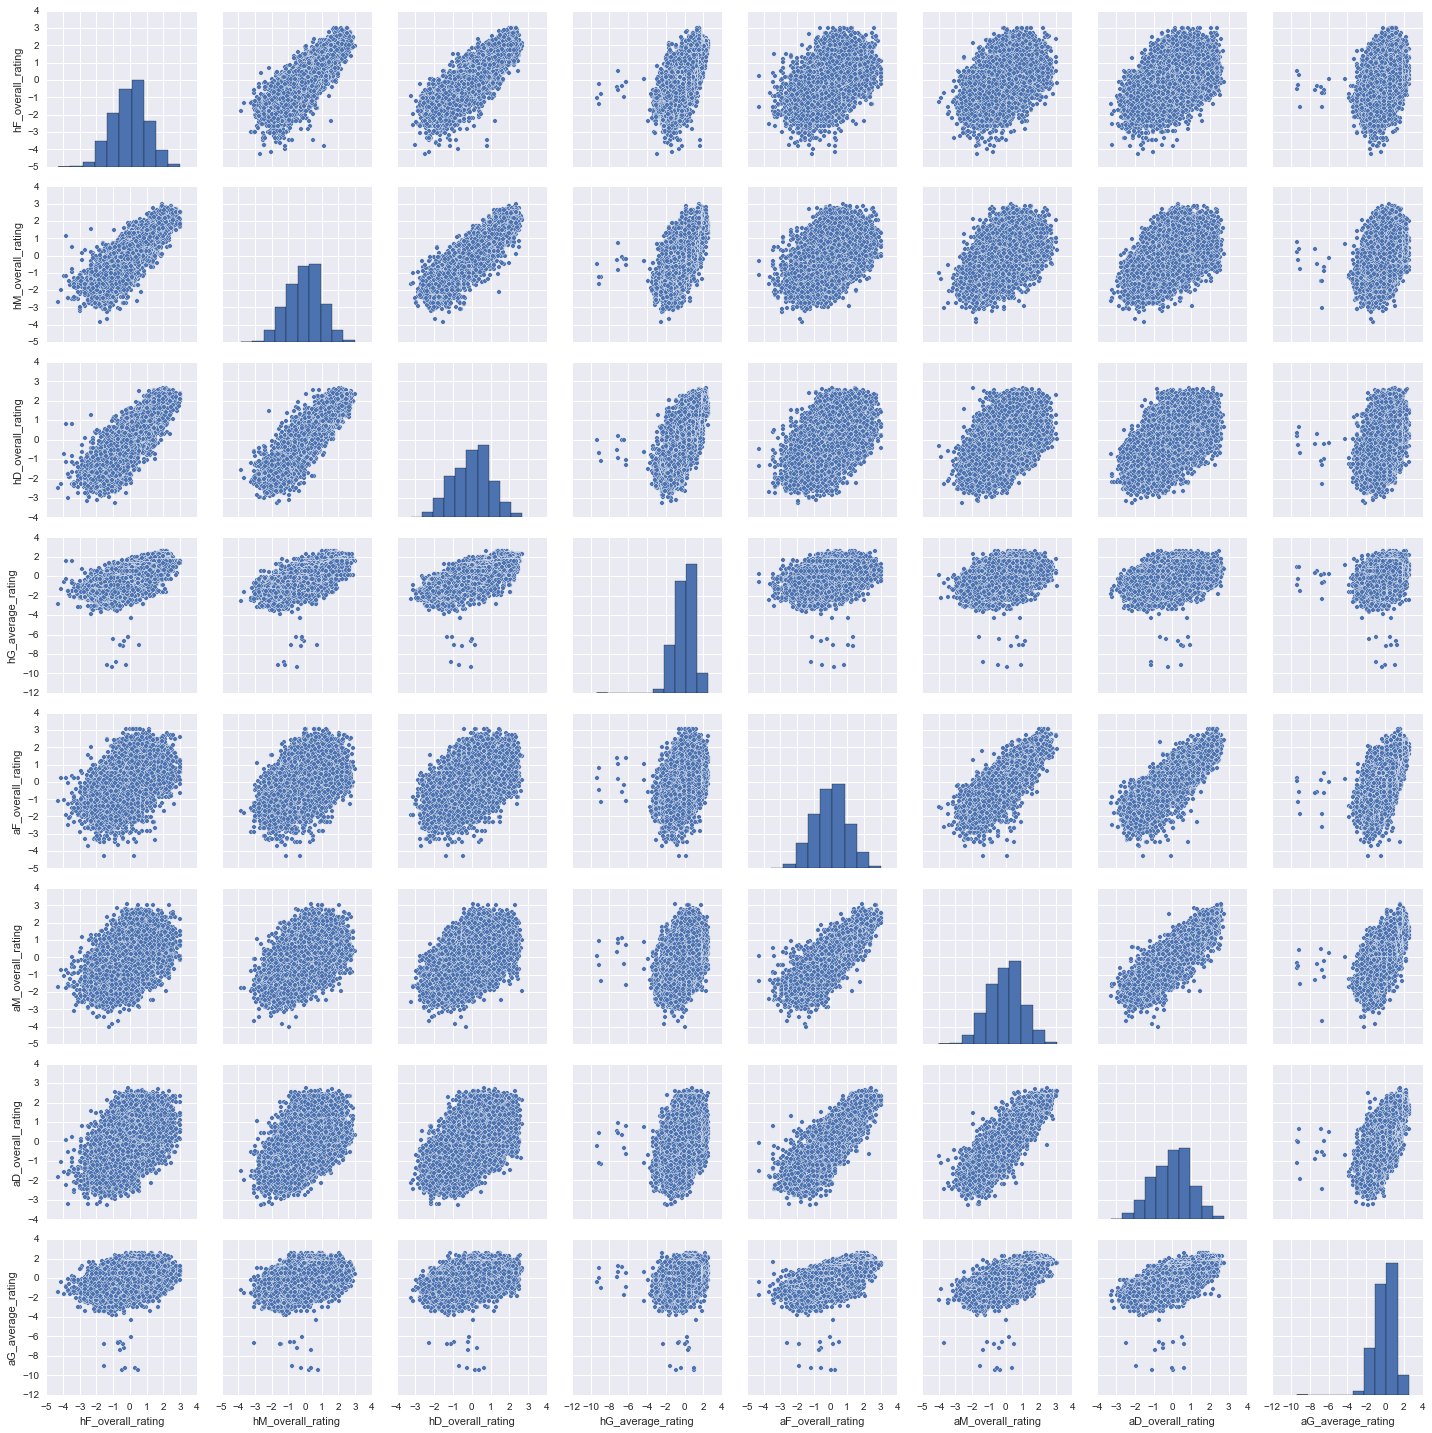

In [164]:
sns.pairplot(pd.DataFrame(X_train_std, columns=feature_subset_1))
plt.savefig('feature_subset_1_pairplot.png', bbox_inches='tight', dpi=144)

__Logistic regression__

Logistic regression requires the hyperparameter `C` to be optimized. This is the regularization strength, which penalizes large weights in the model.

Using K-fold cross validation we'll train a set of models (in this case 5) on a subset of the training data. The held-out data is each case is used to test the model and provide an accuracy score. Finally, the accuracy scores are averaged. Below we repeat this process for a range of `C` values.

In [165]:
c_scores, c_vals = [], []
for c in range(-4,4):
    lr = LogisticRegression(penalty='l1', C=10**c, random_state=0)
    scores = cross_val_score(estimator=lr, X=X_train_std, y=y_train,
                             cv=5, n_jobs=1)
    print('For c = {0:d}, Mean K-fold score = {1:.3f} +/- {2:.3f}'.format(c, np.mean(scores), np.std(scores)))
    c_scores.append(np.mean(scores))
    c_vals.append(c)

For c = -4, Mean K-fold score = 0.458 +/- 0.000
For c = -3, Mean K-fold score = 0.477 +/- 0.006
For c = -2, Mean K-fold score = 0.527 +/- 0.007
For c = -1, Mean K-fold score = 0.526 +/- 0.007
For c = 0, Mean K-fold score = 0.526 +/- 0.007
For c = 1, Mean K-fold score = 0.526 +/- 0.007
For c = 2, Mean K-fold score = 0.526 +/- 0.007
For c = 3, Mean K-fold score = 0.526 +/- 0.007


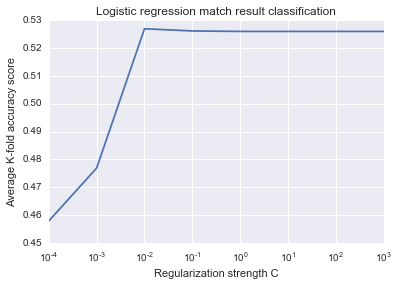

In [166]:
plt.plot([10**c for c in c_vals], c_scores)
plt.title('Logistic regression match result classification')
plt.xlabel('Regularization strength C')
plt.ylabel('Average K-fold accuracy score')
plt.xscale('log')
plt.savefig('feature_subset_1_lr_C.png', bbox_inches='tight', dpi=144)

The accuracy is hovering just above 50%, but we should keep in mind that we have 3 possible results for each match giving a random guess benchmark of 33%.

The K-fold testing above is useful to extract an accuracy score, but we should train our final model on the entire data set. Let's do this and then take a quick look "under the hood".

In [167]:
clf = LogisticRegression(penalty='l1', C=10**(-1),
                         random_state=0)
clf.fit(X_train_std, y_train)
clf

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

What are the `[home-team-win, draw, away-team-win]` probabilities for some random games.

In [168]:
print(clf.predict_proba(X_train_std[0].reshape(1, -1)))
print(clf.predict_proba(X_train_std[1200].reshape(1, -1)))
print(clf.predict_proba(X_train_std[9900].reshape(1, -1)))

[[ 0.17  0.29  0.54]]
[[ 0.67  0.23  0.1 ]]
[[ 0.2   0.28  0.52]]


Scikit-learn automatically trained three classifiers using the one-vs-all method and each has 8 parameters.

In [169]:
clf.coef_.shape

(3, 8)

Let's look at the coefficients of the first trained model, which classifies between wins and _not_ wins. i.e. wins vs draws and losses

In [170]:
np.set_printoptions(2)
print(clf.coef_[0])

[ 0.26  0.33  0.33  0.01 -0.21 -0.23 -0.38 -0.07]


__Random forests__

Will decision trees perform better? Probably not, but we can use them to try and assess feature importance.

Below we perform K-fold cross validation on an ensemble of 1000 decision trees.

In [171]:
N = 1000
clf = RandomForestClassifier(criterion='gini', n_estimators=N)
scores = cross_val_score(estimator=clf, X=X_train, y=y_train,
                         cv=5, n_jobs=1)
print(N, 'estimators trained per fold')
print('Mean k-fold score = {0:.3f} +/- {1:.3f}'.format(np.mean(scores), np.std(scores)))

1000 estimators trained per fold
Mean k-fold score = 0.507 +/- 0.008


A hyperparameter of decision trees is `max_depth`, which we can use to _prune our trees_. Let's plot the mean K-fold accuracy score over a range of `max_depth` values.

In [172]:
N = 1000
max_depth = np.arange(2,15,2)

feature_names = df[feature_subset_1].columns

scores, feature_importances = [], []
for di, d in enumerate(max_depth):
    
    clf = RandomForestClassifier(n_estimators=N, max_depth=d)
    scores.append(cross_val_score(estimator=clf, X=X_train, y=y_train,
                         cv=5, n_jobs=1))
    print('Depth = {0:d}'.format(d),\
          'Mean k-fold score = {0:.3f} +/- {1:.3f}'.format(np.mean(scores[di]), np.std(scores[di])))
    
    clf.fit(X_train_std, y_train)
    feature_importances.append(clf.feature_importances_)

Depth = 2 Mean k-fold score = 0.493 +/- 0.007
Depth = 4 Mean k-fold score = 0.513 +/- 0.005
Depth = 6 Mean k-fold score = 0.522 +/- 0.008
Depth = 8 Mean k-fold score = 0.525 +/- 0.008
Depth = 10 Mean k-fold score = 0.524 +/- 0.009
Depth = 12 Mean k-fold score = 0.521 +/- 0.007
Depth = 14 Mean k-fold score = 0.518 +/- 0.007


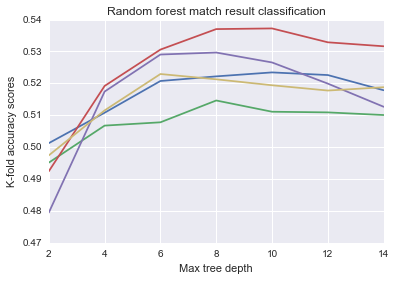

In [173]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(scores)
ax.set_xticks(np.arange(len(scores)))
ax.set_xticklabels(max_depth)
ax.set_title('Random forest match result classification')
ax.set_xlabel('Max tree depth')
ax.set_ylabel('K-fold accuracy scores')
plt.savefig('feature_subset_1_forest_kfold.png', bbox_inches='tight', dpi=144)

Feature importances can be approximated using decision trees, and they are automatically saved as an attribute on the classifier. In the preceding code we appended these values to a list and they are plotted below.

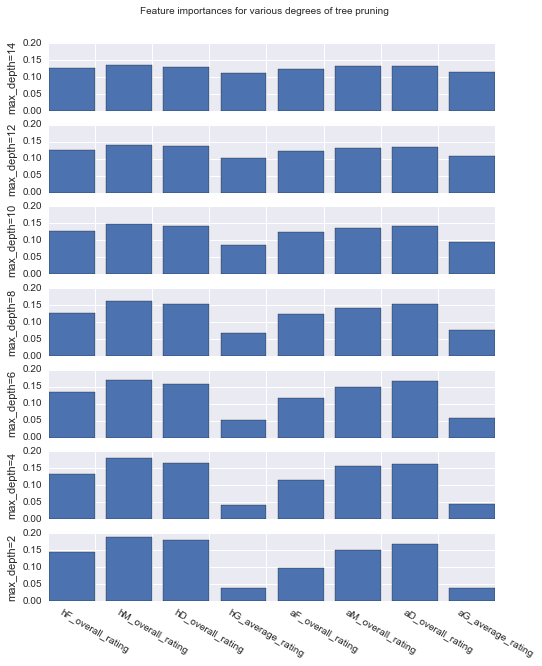

In [174]:
fig, ax = plt.subplots(len(max_depth), 1,
                       sharex=True, sharey=True,
                       figsize=(8, 10))

for di, d in enumerate(max_depth):

    i = len(max_depth)-di-1
    ax[i].bar(np.arange(len(feature_importances[di])),
              feature_importances[di])
    ax[i].set_xticks(np.arange(len(feature_importances[di]))+0.8)
    ax[i].set_xticklabels(feature_subset_1)
    ax[i].set_ylabel('max_depth={}'.format(d))
    plt.setp(ax[i].xaxis.get_majorticklabels(), rotation=-30)
    
plt.suptitle('Feature importances for various degrees of tree pruning', y=0.95)
plt.savefig('feature_subset_1_importances.png', bbox_inches='tight', dpi=144)

Let's print the decision tree for a model fit on the entire data set. With `max_depth = 6` we already have a very complicated tree. 

In [176]:
clf = RandomForestClassifier(n_estimators=1000, max_depth=6, random_state=0)
clf.fit(X_train_std, y_train)
export_graphviz(clf.estimators_[0], out_file='tree_feature_subset_1_max_depth_6.dot',
                feature_names=df[feature_subset_1].columns)

You'll need to have graphviz installed to convert the `.dot` files to `.png`, the relevant command line execution looks like this:
```
dot -Tpng tree.dot -o tree.png
```

In [2]:
from IPython.core.display import Image

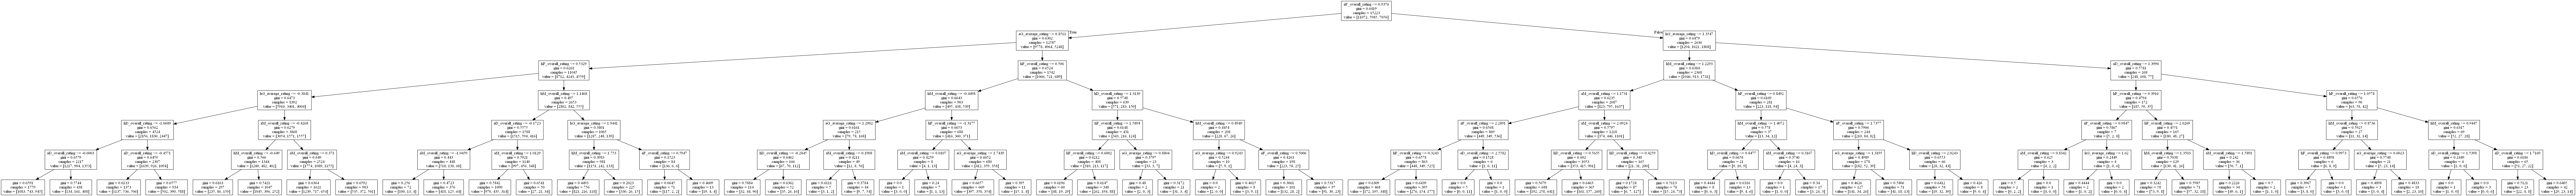

In [178]:
Image('tree_feature_subset_1_max_depth_6.png')

It may be difficult to see anything in the ipython notebook for this size.

Let's look at the tree for `max_depth = 3` and then `max_depth = 2`.

In [179]:
clf = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=0)
clf.fit(X_train_std, y_train)
export_graphviz(clf.estimators_[0], out_file='tree_feature_subset_1_max_depth_3.dot',
                feature_names=df[feature_subset_1].columns)

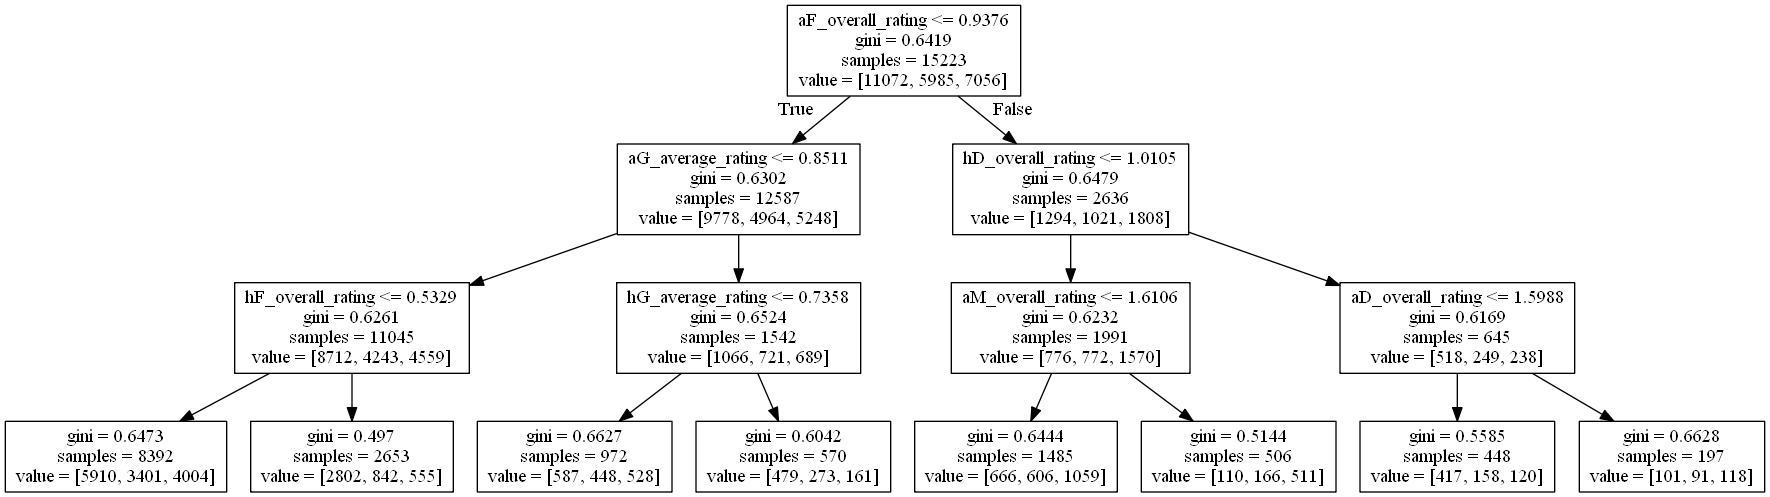

In [184]:
Image('tree_feature_subset_1_max_depth_3.png')

In [180]:
clf = RandomForestClassifier(n_estimators=1000, max_depth=2, random_state=0)
clf.fit(X_train_std, y_train)
export_graphviz(clf.estimators_[0], out_file='tree_feature_subset_1_max_depth_2.dot',
                feature_names=df[feature_subset_1].columns)

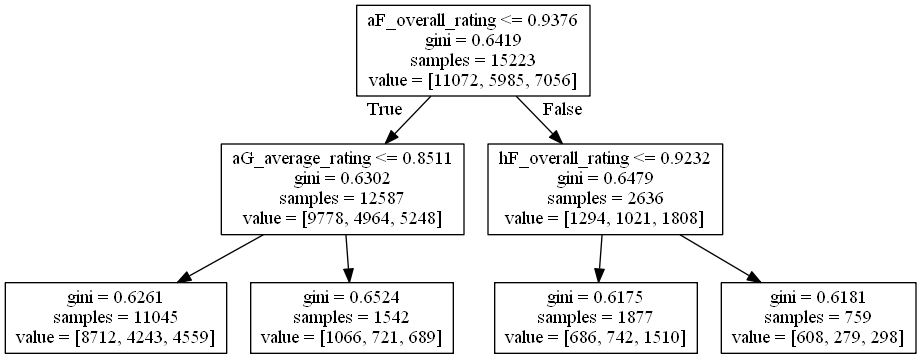

In [185]:
Image('tree_feature_subset_1_max_depth_2.png')

The decision tree splits on the feature that yields the highest information gain (a maximization problem). The `gini` value in each cell is the _information gain_ of the decided feature from which to split on. As well as the gini index, we have access to the _entropy_ information gain.

In [181]:
clf = RandomForestClassifier(n_estimators=1000, max_depth=2, criterion='entropy', random_state=0)
clf.fit(X_train_std, y_train)
export_graphviz(clf.estimators_[0], out_file='tree_feature_subset_1_max_depth_2_entropy.dot',
                feature_names=df[feature_subset_1].columns)

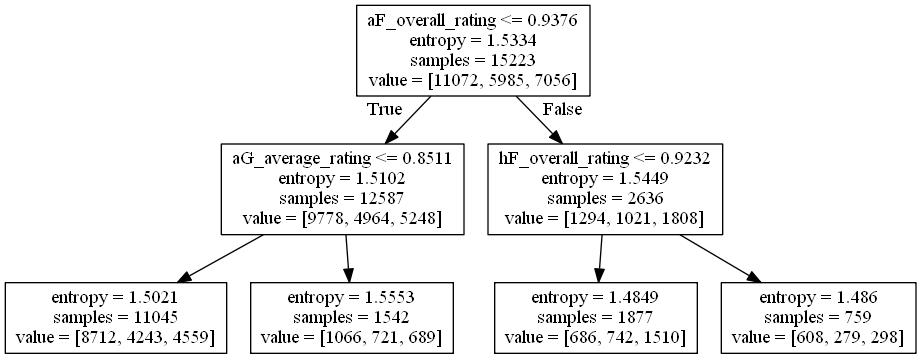

In [186]:
Image('tree_feature_subset_1_max_depth_2_entropy.png')

The `value` list in each cell holds the number of samples that land in that bin. These generate the probabilities of our selection. For example the bottom right list has 420 home team wins, 232 draws, and 295 home team losses. The prediction for samples landing in the cell would be that the home team wins. 

In [182]:
np.set_printoptions(2)
print(clf.predict_proba(X_train_std[0].reshape(1,-1)))
print(clf.predict_proba(X_train_std[4095].reshape(1,-1)))
print(clf.predict_proba(X_train_std[5990].reshape(1,-1)))
print(clf.predict_proba(X_train_std[5830].reshape(1,-1)))

[[ 0.44  0.27  0.29]]
[[ 0.29  0.25  0.46]]
[[ 0.67  0.2   0.13]]
[[ 0.34  0.26  0.4 ]]


These four class prediction probabilities correspond to the four final cells in the tree. As seen below, we can calculate probabilities based on the `value` list showing class populations.

In [183]:
value = [[7400, 4330, 4551], [967, 861, 1765], [2267, 630, 395], [420, 232, 295]]
np.array([[v/sum(val) for v in val] for val in value])

array([[ 0.45,  0.27,  0.28],
       [ 0.27,  0.24,  0.49],
       [ 0.69,  0.19,  0.12],
       [ 0.44,  0.24,  0.31]])